<a href="https://colab.research.google.com/github/cppel/dz/blob/main/Task6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №6. Проектирование автоэнкодеров для решения прикладных задач**

[**Ссылка на код с пары**](https://colab.research.google.com/drive/1KfCEQly5k0PUdCR1w-my2-QmYfFexdvK?usp=sharing)

# Задание №1. Реализуйте автоэнкодер для колоризации чёрно-белых изображений

* **Чем больше объектов разных классов будет в исходном датасете, тем универсальнее будет работа обученной Вами модели**

> Например, если в Вашем датасете только кошки, то все объекты кроме кошек будут колоризоваться некорректно. Соответственно следует очень тщательно подойти к выбору датасета. 

  * Для решения данной задачи может подойти датасет [CIFAR-100](https://www.kaggle.com/datasets/fedesoriano/cifar100), но его минус заключается в том, что разрешение изображений довольно низкое

* Хорошим вариантом будет использование датасета [ImageNet](https://paperswithcode.com/dataset/imagenet), но ввиду его объёмности, процесс обучения займет большое количество времени, поэтому Вы можете использовать одну из его [сокращенных версий](https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000)

 **Конечный выбор датасета осуществляется по Вашему желанию, учитывая рекомендации приведенные выше.**

В силу сложности обучения исходя из сокращенного датасета (6 дней надо чтобы обучить используя GPU), решил выбрать один класс раскрашивания для Common-Kingfisher из предыдущей работы.

In [ ]:
from tensorflow import keras
from keras.layers import Conv2D, UpSampling2D, Input, Conv2DTranspose
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb, rgb2gray
from skimage.transform import resize
from skimage.io import imsave
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
import keras
import cv2
import os
from tensorflow.keras.optimizers import Adam

In [ ]:
# В качестве энкодера используем предобученную модель VGG19
from keras.applications.vgg19 import VGG19
# Импортируем предобученную модель VGG19, оставляя только слои, используемые для извлечения признаков
encoder_model = VGG19(include_top=False, input_shape=(224, 224, 3))

encoder_model.trainable = False

encoder_model.summary()

80150528/80134624 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
autoencoder_model = Sequential()
autoencoder_model.add(encoder_model)
autoencoder_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
autoencoder_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder_model.add(UpSampling2D((2, 2)))
autoencoder_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder_model.add(UpSampling2D((2, 2)))
autoencoder_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder_model.add(UpSampling2D((2, 2)))
autoencoder_model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
autoencoder_model.add(UpSampling2D((2, 2)))
autoencoder_model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
autoencoder_model.add(UpSampling2D((2, 2)))
autoencoder_model.summary()

autoencoder_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 256)         1179904   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         295040    
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 up_sampling2d_1 (UpSampling  (None, 28, 28, 64)       0         
 2D)                                                    

In [ ]:
seed = 24
batch_size = 64

In [ ]:
def prepocess_image(image):
        lab = rgb2lab(image)
        x = gray2rgb(lab[:,:,0])
        x = keras.applications.vgg19.preprocess_input(x)
        y = lab[:,:,1:] / 128
        return (x, y)

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def preprocess_data(images):
    max_workers = 8
    X = []
    Y = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for image in images:
            future = executor.submit(prepocess_image, image)
            futures.append(future)
        

        for future in as_completed(futures):
            x, y = future.result()
            X.append(x)
            Y.append(y)

    X = np.asarray(X)
    Y = np.asarray(Y)

    return (X, Y)

In [ ]:
def get_filenames(path):
    img_data_gen_args = dict(horizontal_flip=False,
                             vertical_flip=False)
    image_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        path,
        class_mode=None,
        target_size=(224, 224),
        batch_size=batch_size,
        seed=seed)
    return image_generator.filenames

In [ ]:
def trainGenerator(train_img_path):

    img_data_gen_args = dict(horizontal_flip=False,
                             vertical_flip=False)

    image_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode=None,
        target_size=(224, 224),
        batch_size=batch_size,
        seed=seed)

    for img in image_generator:
        gray, orig = preprocess_data(img)
        yield (gray, orig)

In [ ]:
train_img_path = r'C:\Users\work\Downloads\test-20230521T162222Z-001\test\train'
train_img_gen = trainGenerator(train_img_path)

val_img_path = r'C:\Users\work\Downloads\test-20230521T162222Z-001\test\valid'
val_img_gen = trainGenerator(val_img_path)

In [ ]:
filenames = get_filenames(train_img_path)
steps_per_epoch_train = len(filenames) // batch_size

Found 1500 images belonging to 1 classes.


In [ ]:
filenames = get_filenames(val_img_path)
steps_per_epoch_val = len(filenames) // batch_size

Found 300 images belonging to 1 classes.


In [ ]:
history = autoencoder_model.fit(
    train_img_gen,
    steps_per_epoch=steps_per_epoch_train,
    validation_steps=steps_per_epoch_val,
    batch_size=batch_size,
    epochs=100,
    verbose=1,
    validation_data=val_img_gen
    )

Found 1500 images belonging to 1 classes.
Epoch 1/100
23/23 [==============================] - 32s 959ms/step - loss: 145.2814 - accuracy: 0.6043 - val_loss: 136.2554 - val_accuracy: 0.7519
Epoch 2/100
23/23 [==============================] - 16s 592ms/step - loss: 138.9217 - accuracy: 0.7767 - val_loss: 136.9145 - val_accuracy: 0.7488
Epoch 3/100
23/23 [==============================] - 13s 585ms/step - loss: 139.0780 - accuracy: 0.7831 - val_loss: 133.1918 - val_accuracy: 0.7541
Epoch 4/100
23/23 [==============================] - 13s 589ms/step - loss: 139.8325 - accuracy: 0.7835 - val_loss: 133.8386 - val_accuracy: 0.7427
Epoch 5/100
23/23 [==============================] - 13s 585ms/step - loss: 136.7027 - accuracy: 0.7787 - val_loss: 135.0134 - val_accuracy: 0.7520
Epoch 6/100
23/23 [==============================] - 13s 579ms/step - loss: 138.2094 - accuracy: 0.7775 - val_loss: 135.9225 - val_accuracy: 0.7489
Epoch 7/100
23/23 [==============================] - 13s 580ms/step - 

In [ ]:
autoencoder_model.save('/content/drive/MyDrive/colorize_autoencoder_VGG19.h5')

In [ ]:
def predict(imagePath):
    orig = img_to_array(load_img(imagePath))
    test = orig.copy()
    test = resize(test, (224,224), anti_aliasing=True)
    test *= 1.0/255
    lab = rgb2lab(test)
    l = lab[:,:,0]
    L = gray2rgb(l)
    L = L.reshape((1,224,224,3))
    L = keras.applications.vgg19.preprocess_input(L)
    ab = autoencoder_model.predict(L)

    ab = ab*128
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = l
    cur[:,:,1:] = ab
    
    rgb = cv2.cvtColor(cur.astype('uint8'), cv2.COLOR_LAB2RGB)
    plt.figure(figsize=(10, 5))

    orig_plt = plt.subplot(1, 3, 1)
    orig_plt.imshow(orig.astype("uint8"))
    orig_plt.set_title("original")
    orig_plt.axis("off")

    gray_plt = plt.subplot(1, 3, 2)
    gray_plt.set_title("GRAY")
    gray_plt.axis("off")
    gray_plt.imshow(l.astype("uint8"), cmap=plt.cm.gray)

    rgb_plt = plt.subplot(1, 3, 3)
    rgb_plt.imshow(rgb.astype("uint8"))
    rgb_plt.set_title("RGB recovered")
    rgb_plt.axis("off")

1/1 [==============================] - 0s 21ms/step


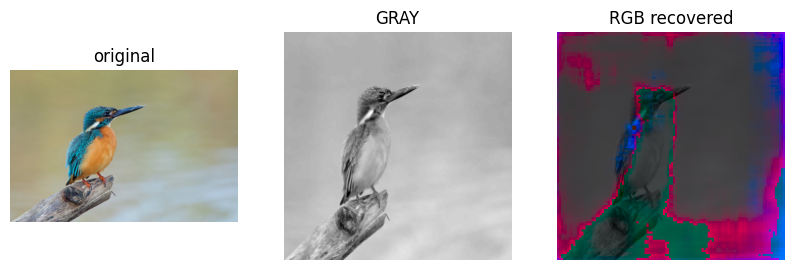

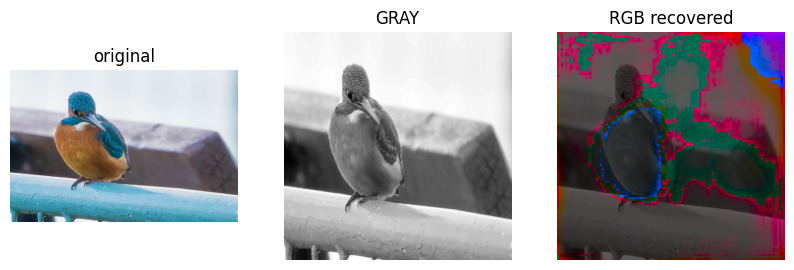

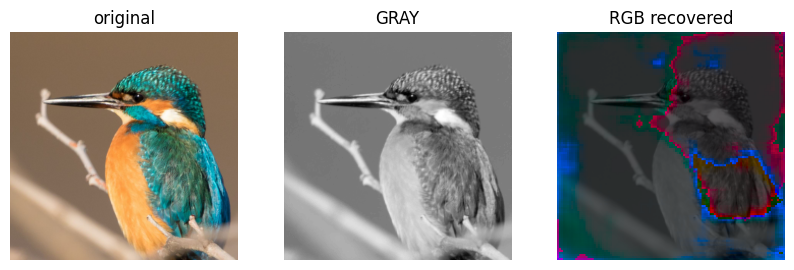

In [ ]:
from imutils import paths
imagePaths = sorted(list(paths.list_images(r"/content/drive/MyDrive/task6/colorize/")))
for imagePath in imagePaths:
    predict(imagePath)

# Задание №2. Реализуйте автоэнкодер для удаления шума на однотипных изображениях

1.  Подберите датасет, состоящий из однотипных изображений, которые в реальной жизни часто подвержены зашумлению, например спутниковые снимки, ночные фотографии и т.д.

2.  Затем примените к ним операцию зашумления и обучите модель. Также учитывайте тип шума, который Вы применяете. Он должен быть приближен к естественному.

Хороший пример реализации подобной задачи: https://www.kaggle.com/code/michalbrezk/denoise-images-using-autoencoders-tf-keras
Датасет фото с шумом и без https://www.eecs.yorku.ca/~kamel/sidd/dataset.php

In [ ]:
import matplotlib.pyplot as plt
from tensorflow import keras
import cv2
import numpy as np
from keras import layers
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from imutils import paths
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
input = layers.Input(shape=(220, 220, 3)) 

e_conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input)
pool1 = layers.MaxPooling2D((2, 2), padding='same')(e_conv1)
batchnorm_1 = layers.BatchNormalization()(pool1)

e_conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(batchnorm_1)
pool2 = layers.MaxPooling2D((2, 2), padding='same')(e_conv2)
batchnorm_2 = layers.BatchNormalization()(pool2)

e_conv3 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(batchnorm_2)
h = layers.MaxPooling2D((2, 2), padding='same')(e_conv3)

d_conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(h)
up1 = layers.UpSampling2D((2, 2))(d_conv1)

d_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
up2 = layers.UpSampling2D((2, 2))(d_conv2)

d_conv3 = layers.Conv2D(16, (3, 3), activation='relu')(up2)
up3 = layers.UpSampling2D((2, 2))(d_conv3)
    
r = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)

autoencoder = Model(input, r)
autoencoder.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 220, 220, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 110, 110, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0     

In [ ]:
seed = 24
batch_size = 64

In [ ]:
def preprocess_data(img, watermark):
    img = img.astype("float32") / 255.0
    watermark = watermark.astype("float32") / 255.0
    img = np.reshape(img, (len(img), 220, 220, 3))
    watermark = np.reshape(watermark, (len(watermark), 220, 220, 3))
      
    return (img, watermark)

In [ ]:
def trainGenerator(train_img_path, watermark_img_path):

    img_data_gen_args = dict(horizontal_flip=False,
                             vertical_flip=False)

    image_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode=None,
        target_size=(220, 220),
        batch_size=batch_size,
        seed=seed)
    
    watermark_generator = image_datagen.flow_from_directory(
        watermark_img_path,
        class_mode=None,
        target_size=(220, 220),
        batch_size=batch_size,
        seed=seed)

    train_generator = zip(image_generator, watermark_generator)
    
    for (img, watermark) in train_generator:
        img, watermark = preprocess_data(img, watermark)
        yield (img, watermark)

In [ ]:
def get_filenames(path):
    img_data_gen_args = dict(horizontal_flip=False,
                             vertical_flip=False)
    image_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        path,
        class_mode=None,
        target_size=(220, 220),
        batch_size=batch_size,
        seed=seed)
    return image_generator.filenames

In [ ]:
train_img_path = r'/content/drive/MyDrive/wm-nowm/train/gt'
watermark_img_path = r'/content/drive/MyDrive/wm-nowm/train/w'
train_img_gen = trainGenerator(train_img_path, watermark_img_path)

valid_img_path = r'/content/drive/MyDrive/wm-nowm/valid/gt'
valid_watermark_img_path = r'/content/drive/MyDrive/wm-nowm/valid/w'
valid_img_gen = trainGenerator(valid_img_path, valid_watermark_img_path)

In [ ]:
filenames = get_filenames(train_img_path)
steps_per_epoch_train = len(filenames) // batch_size

Found 2016 images belonging to 1 classes.


In [ ]:
filenames = get_filenames(valid_img_path)
steps_per_epoch_val = len(filenames) // batch_size

Found 224 images belonging to 1 classes.


In [ ]:
history = autoencoder.fit(
    train_img_gen,
    steps_per_epoch=steps_per_epoch_train,
    batch_size=batch_size,
    epochs=30,
    verbose=1,
    validation_steps=steps_per_epoch_val,
    validation_data=valid_img_gen
    )

Found 2016 images belonging to 1 classes.
Found 2016 images belonging to 1 classes.
Epoch 1/30
31/31 [==============================] - ETA: 0s - loss: 0.0345 Found 224 images belonging to 1 classes.
Found 224 images belonging to 1 classes.
31/31 [==============================] - 402s 13s/step - loss: 0.0345 - val_loss: 0.0688
Epoch 2/30
31/31 [==============================] - 29s 913ms/step - loss: 0.0217 - val_loss: 0.0636
Epoch 3/30
31/31 [==============================] - 27s 900ms/step - loss: 0.0198 - val_loss: 0.0619
Epoch 4/30
31/31 [==============================] - 29s 969ms/step - loss: 0.0192 - val_loss: 0.0597
Epoch 5/30
31/31 [==============================] - 31s 1s/step - loss: 0.0187 - val_loss: 0.0552
Epoch 6/30
31/31 [==============================] - 29s 950ms/step - loss: 0.0181 - val_loss: 0.0503
Epoch 7/30
31/31 [==============================] - 28s 915ms/step - loss: 0.0180 - val_loss: 0.0457
Epoch 8/30
31/31 [==============================] - 26s 873ms/step 

In [ ]:
autoencoder.save('/content/drive/MyDrive/denoise_autoencoder.h5')

In [ ]:
from keras.utils import img_to_array, load_img
from skimage.transform import resize

def predict(imagePath):
    orig = img_to_array(load_img(imagePath))
    test = orig.copy()
    test = resize(test, (220,220), anti_aliasing=True)
    test *= 1.0/255
    test = test.reshape((1,220,220,3))
    pred = autoencoder.predict(test)

    pred = pred[0]*256

    plt.figure(figsize=(10, 5))

    orig_plt = plt.subplot(1, 2, 1)
    orig_plt.set_title("Waterarked")
    orig_plt.axis("off")
    orig_plt.imshow(orig.astype("uint8"))

    clean_plt = plt.subplot(1, 2, 2)
    clean_plt.set_title("Cleaned")
    clean_plt.axis("off")
    clean_plt.imshow(pred.astype("uint8"))

1/1 [==============================] - 0s 32ms/step


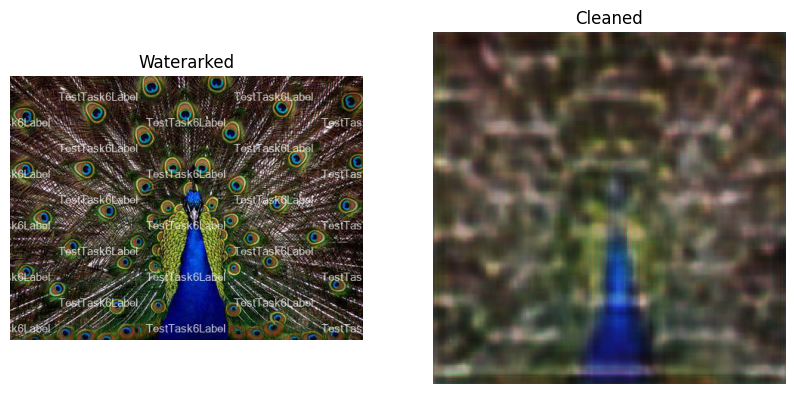

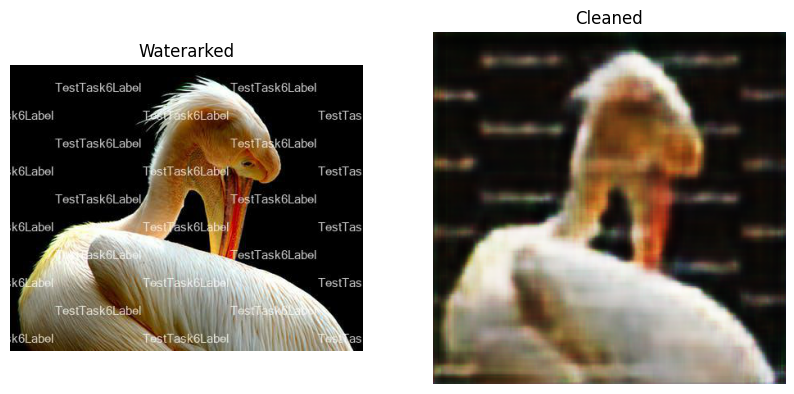

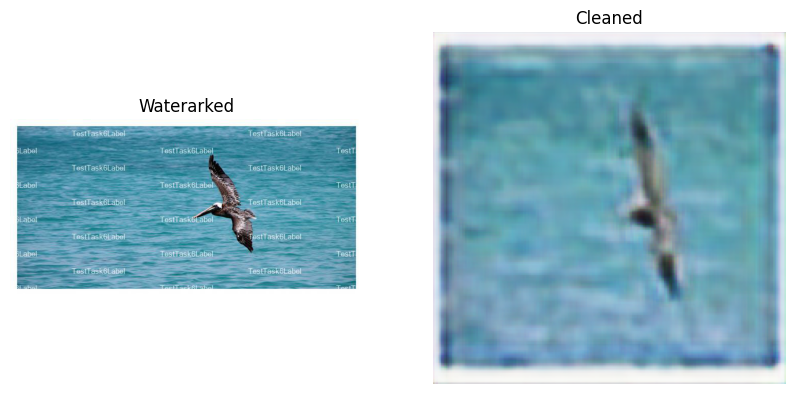

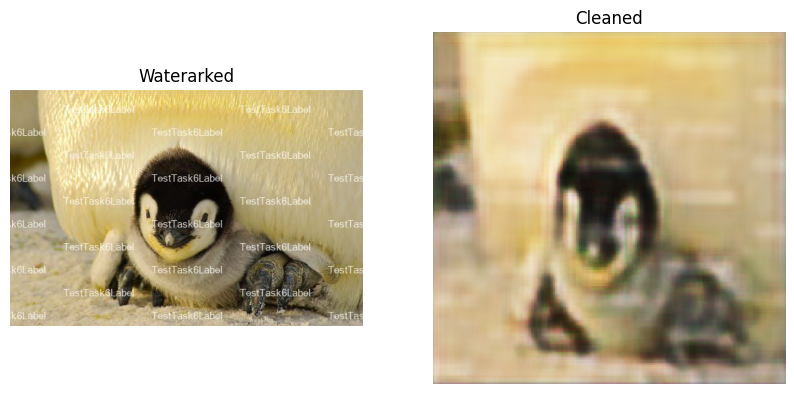

In [ ]:
from imutils import paths
imagePaths = sorted(list(paths.list_images(r"/content/drive/MyDrive/water_mark_test")))
for imagePath in imagePaths:
    predict(imagePath)

# Задание №.3 Реализуйте автоэнкодер для улучшения качества изображения путём увеличения его разрешения (апскейлинг-[определение](https://dic.academic.ru/dic.nsf/ruwiki/346555))

1. На входной слой нейронной сети подаётся изображение с размерностью (256, 256,3) - X_test. В результате работы нейронной сети на выходном слое должно получиться изображение (512, 512, 3) - Y_test. В итоге мы получаем двукратный апскейл исходного изображения.

2. Датасет собираете из изображений, разрешение которых выше эталонного (512,512,3). Затем преобразуете их в указанные размерности и формируете из них обучающую и проверочную выборку. 

3. Обучите модель. Отобразите графики обучения

4. Подумайте, каким образом можно будет адаптировать модель вашей нейронной сети для двухратного апскейла изображения с любой размерностью, большей, чем (256,256,3), с полным или частичным сохранением его исходных пропорций. Например: подаём на вход изображение с разрешением (1920, 1080, 3) - получаем изображение с разрешением (3840, 2160, 3), т.е. с полным сохранением исходных пропорций или (1792, 1024, 3) с частичным сохранением исходных пропорций.

> Подсказка: Для этого можно реализовать алгоритм предварительной обработки исходного изображения, перед подачей его в нейронную сеть

In [ ]:
import matplotlib.pyplot as plt
from tensorflow import keras
import cv2
import numpy as np
from keras import layers
from keras.layers import Dense, Flatten
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from imutils import paths
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
input = layers.Input(shape=(256, 256, 3)) 

e_conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input)
pool1 = layers.MaxPooling2D((2, 2), padding='same')(e_conv1)
batchnorm_1 = layers.BatchNormalization()(pool1)

e_conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(batchnorm_1)
pool2 = layers.MaxPooling2D((2, 2), padding='same')(e_conv2)
batchnorm_2 = layers.BatchNormalization()(pool2)

e_conv3 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(batchnorm_2)
h = layers.MaxPooling2D((2, 2), padding='same')(e_conv3)

d_conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(h)
up1 = layers.UpSampling2D((2, 2))(d_conv1)

d_conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
up2 = layers.UpSampling2D((2, 2))(d_conv2)

d_conv3 = layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(up2)
up3 = layers.UpSampling2D((2, 2))(d_conv3)

d_conv4 = layers.Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(up3)
up4 = layers.UpSampling2D((2, 2))(d_conv4)

r = layers.Conv2D(3, (3, 3), activation='relu', padding='same')(up4)

autoencoder = Model(input, r)
autoencoder.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0     

In [ ]:
seed = 24
batch_size = 32

In [ ]:
def preprocess_data(img, hd_img):
    img = img.astype("float32") / 255.0
    hd_img = hd_img.astype("float32") / 255.0
    img = img.reshape(len(img), 256, 256, 3)
    hd_img = hd_img.reshape((len(hd_img), 512, 512, 3))
      
    return (img, hd_img)

In [ ]:
def trainGenerator(train_img_path, hd_img_path):

    img_data_gen_args = dict(horizontal_flip=False,
                             vertical_flip=False)

    image_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode=None,
        target_size=(256, 256),
        batch_size=batch_size,
        seed=seed)
    
    hd_img_generator = image_datagen.flow_from_directory(
        hd_img_path,
        class_mode=None,
        target_size=(512, 512),
        batch_size=batch_size,
        seed=seed)

    train_generator = zip(image_generator, hd_img_generator)
    
    for (img, hd_img) in train_generator:
        img, hd_img = preprocess_data(img, hd_img)
        yield (img, hd_img)

In [ ]:
def get_filenames(path):
    img_data_gen_args = dict(horizontal_flip=False,
                             vertical_flip=False)
    image_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        path,
        class_mode=None,
        target_size=(220, 220),
        batch_size=batch_size,
        seed=seed)
    return image_generator.filenames

In [ ]:
train_img_path = r'C:\Users\work\Downloads\resize-20230509T200644Z-001\resize/train/low/'
train_hd_img_path = r'C:\Users\work\Downloads\resize-20230509T200644Z-001\resize/train/high/'
train_img_gen = trainGenerator(train_img_path, train_hd_img_path)

valid_img_path = r'C:\Users\work\Downloads\resize-20230509T200644Z-001\resize/val/low/'
valid_hd_img_path = r'C:\Users\work\Downloads\resize-20230509T200644Z-001\resize/val/high/'
valid_img_gen = trainGenerator(valid_img_path, valid_hd_img_path)

In [ ]:
filenames = get_filenames(train_img_path)
steps_per_epoch_train = len(filenames) // batch_size

Found 1200 images belonging to 1 classes.


In [ ]:
filenames = get_filenames(valid_img_path)
steps_per_epoch_val = len(filenames) // batch_size

Found 300 images belonging to 1 classes.


In [ ]:
history = autoencoder.fit(
    train_img_gen,
    steps_per_epoch=steps_per_epoch_train,
    batch_size=batch_size,
    epochs=30,
    verbose=1,
    validation_steps=steps_per_epoch_val,
    validation_data=valid_img_gen
    )

Found 1200 images belonging to 1 classes.
Found 1200 images belonging to 1 classes.
Epoch 1/30
37/37 [==============================] - ETA: 0s - loss: 0.1619Found 300 images belonging to 1 classes.
Found 300 images belonging to 1 classes.
37/37 [==============================] - 24s 562ms/step - loss: 0.1619 - val_loss: 0.2051
Epoch 2/30
37/37 [==============================] - 18s 446ms/step - loss: 0.1295 - val_loss: 0.1412
Epoch 3/30
37/37 [==============================] - 16s 443ms/step - loss: 0.0766 - val_loss: 0.1087
Epoch 4/30
37/37 [==============================] - 16s 433ms/step - loss: 0.0739 - val_loss: 0.0870
Epoch 5/30
37/37 [==============================] - 17s 451ms/step - loss: 0.0735 - val_loss: 0.0908
Epoch 6/30
37/37 [==============================] - 17s 465ms/step - loss: 0.0730 - val_loss: 0.0862
Epoch 7/30
37/37 [==============================] - 17s 462ms/step - loss: 0.0732 - val_loss: 0.0731
Epoch 8/30
37/37 [==============================] - 17s 463ms/st

In [ ]:
autoencoder.save(r'C:\Users\work\Downloads\task6_models/upscale_autoencoder.h5')

In [ ]:
from tensorflow.keras.utils import img_to_array, load_img
from skimage.transform import resize

def predict(imagePath):
    orig = img_to_array(load_img(imagePath))
    test = orig.copy()
    test = resize(test, (256,256), anti_aliasing=True)
    test *= 1.0/255
    test = test.reshape((1,256,256,3))
    pred = autoencoder.predict(test)

    pred = pred[0]*256

    plt.figure(figsize=(10, 5))

    orig_plt = plt.subplot(1, 2, 1)
    orig_plt.set_title("Low res")
    orig_plt.axis("off")
    orig_plt.imshow(orig.astype("uint8"))

    clean_plt = plt.subplot(1, 2, 2)
    clean_plt.set_title("Upscaled")
    clean_plt.axis("off")
    clean_plt.imshow(pred.astype("uint8"))

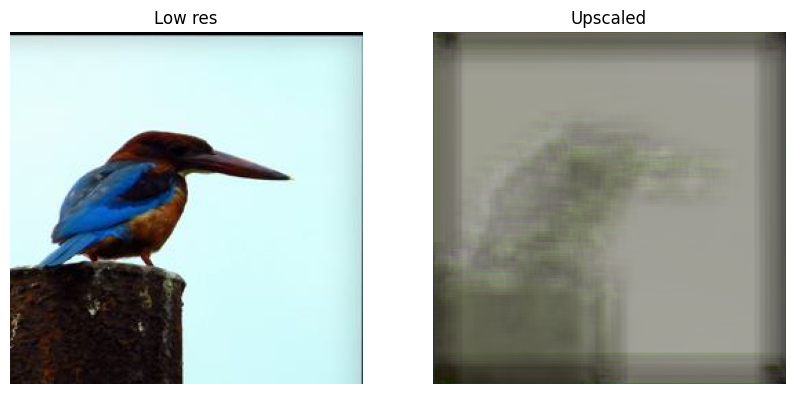

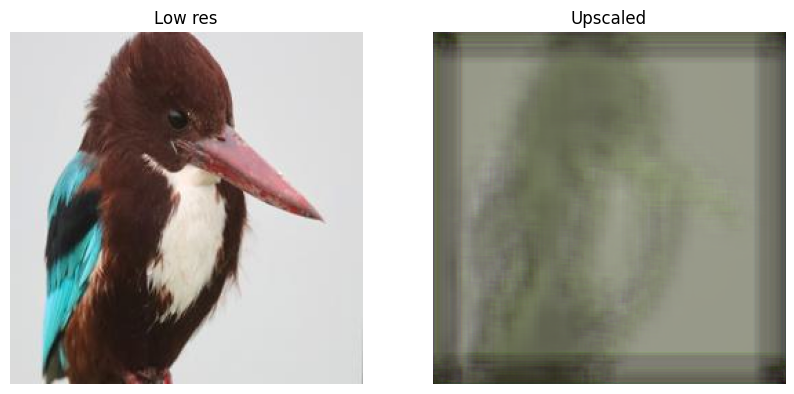

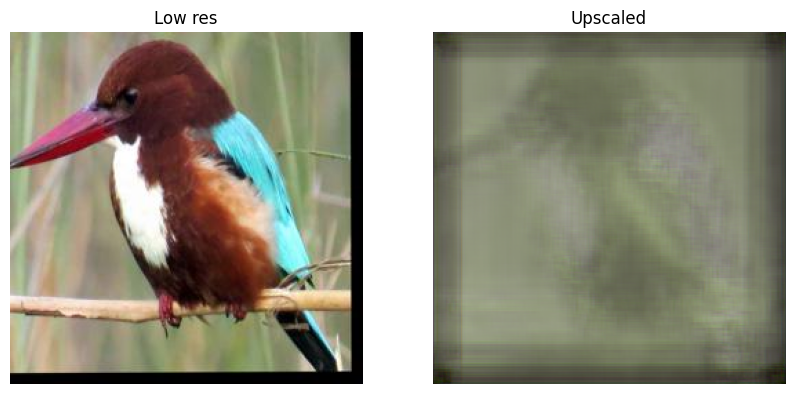

In [ ]:
from imutils import paths
imagePaths = sorted(list(paths.list_images(r"C:\Users\work\Downloads\resize-20230509T200644Z-001\resize\val\test_size")))
for imagePath in imagePaths:
    predict(imagePath)